## Get the data

In [1]:
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qstools as qs
from qstools.interfaces import DbIndicatorsInterface
import math
import yaml

import warnings
warnings.simplefilter('ignore')

Alternative: C:\ProgramData\Anaconda3\lib\site-packages\qstools\__init__.py win32


In [2]:
cats = ['CRIGXR', 'CRHYXR', 'CRIGCRY', 'CRHYCRY']
cids = ['EUR', 'USD']

In [3]:
from_DB = True
path = "..//..//data//feathers//"

with open("..//..//config.yml", 'r') as f:
    cf = yaml.load(f, Loader=yaml.FullLoader)

if from_DB:
    with DbIndicatorsInterface(username=cf["db"]["username"],
                               password=cf["db"]["password"],
                               host=cf["db"]["host"],
                               database=cf["db"]["database"]) as dbi:
        dfd = dbi.get_series_values(category=cats, frequency="d")
        dfd.to_feather(f'{path}dfd_crxrcr.tr')      
else:
    dfd = pd.read_feather(f'{pathr}dfd_crxrcr.tr')

In [4]:
dfd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38000 entries, 0 to 37999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cross_section     38000 non-null  object 
 1   category_code     38000 non-null  object 
 2   adjustment        38000 non-null  object 
 3   transformation    0 non-null      object 
 4   release_date      38000 non-null  object 
 5   observation_date  38000 non-null  object 
 6   value             38000 non-null  float64
 7   grading           38000 non-null  object 
dtypes: float64(1), object(7)
memory usage: 2.3+ MB


## Preparations

In [12]:
dfd['xcid'] = dfd['cross_section'] + '_' + dfd['category_code'].str[:4]  # extended cross section
dfd['cat'] = dfd['category_code'].str[4:]  # core category

In [5]:
dfd_x = dfd[['cross_section', 'category_code', 'release_date']].sort_values('cross_section')
df_rstarts = dfd_x.groupby(['cross_section', 'category_code']).min()
df_rstarts['release_date'] = pd.DatetimeIndex(df_rstarts.loc[:,'release_date']).year
df_rstarts = df_rstarts.unstack().loc[:,'release_date']  # for availability

In [34]:
def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    sns.set(style='whitegrid')
    plt.figure(figsize=(7, 6))
    p1 = sns.scatterplot(x, y, data=data, size = 6, legend=False)
    # Add text besides each point
    for line in range(0,data.shape[0]):
         p1.text(data[x][line]+0.01, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='medium', color='black', weight='semibold')
    # Set title and axis labels
    plt.title(title, fontdict = {'fontsize': 16})
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return p1

## Availability

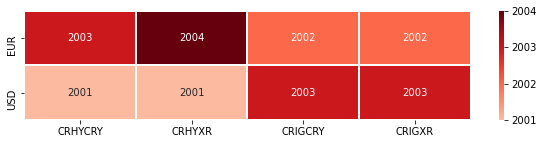

In [9]:
plt.figure(figsize=(10, 2))
sns.heatmap(df_rstarts.sort_index(), 
            cmap='Reds', center=2002,
           annot=True, fmt='.0f', linewidth=1)
plt.xlabel('')
plt.ylabel('')
plt.show()

## Returns

### Distribution

In [21]:
needed = ['xcid', 'cat', 'release_date', 'value']
filt1 = dfd['cat'] == 'XR'
filt2 = dfd['release_date'] >= pd.to_datetime('01-06-1999')
dfd_crxr = dfd[filt1 & filt2].sort_values(['xcid', 'release_date'])[needed]\
    .reset_index(drop=True)

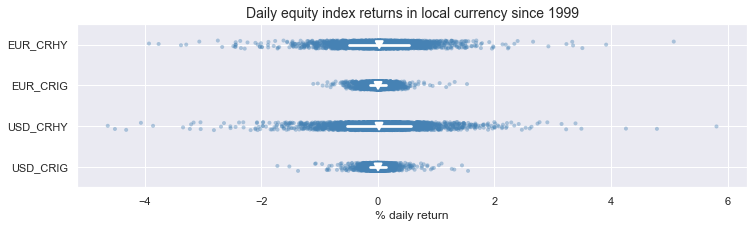

In [28]:
plt.figure(figsize=(12, 3))
sns.set(style='darkgrid')
ax = sns.stripplot(data=dfd_crxr, # show individual observations
                   x="value", y="xcid",
                   dodge=True, alpha=.4, zorder=1, color='steelblue', size = 4)
sns.pointplot(data=dfd_crxr,  # show means/standard deviations
              x="value",  y="xcid",
              dodge=.4, join=False, color='white',
              markers="v", scale=1, alpha=1, ci='sd')
ax.set_title('Daily equity index returns in local currency since 1999', y = 1, fontsize=14)
ax.set(xlabel='% daily return', ylabel='')
plt.grid(axis='y')
plt.show()

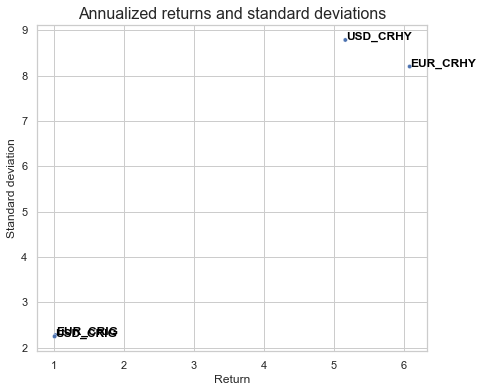

In [35]:
dfd_gpe = dfd_crxr.groupby('xcid').agg(['mean', 'std'])
dfd_gpe.columns = ['Annualized mean', 'Annualized standard deviation']
dfd_gpe['Annualized mean'] = dfd_gpe['Annualized mean'] * 252
dfd_gpe['Annualized standard deviation'] = dfd_gpe['Annualized standard deviation'] * 252**0.5
scatter_text('Annualized mean', 'Annualized standard deviation', 'xcid',
             data = dfd_gpe.reset_index(), 
             title = 'Annualized returns and standard deviations', 
             xlabel = 'Return',
             ylabel = 'Standard deviation')
plt.show()

### Timeline

In [36]:
dfd_crxr['cum_value'] = dfd_crxr.groupby('xcid').cumsum()

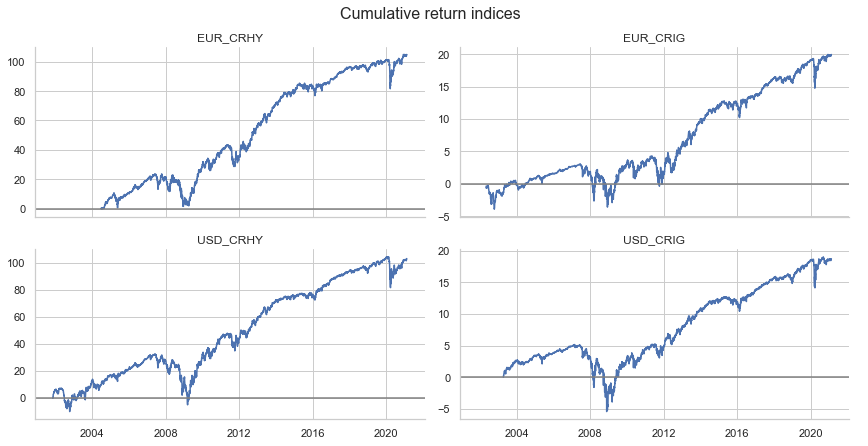

In [39]:
fg = sns.FacetGrid(dfd_crxr, col='xcid', col_wrap = 2, sharey=False, aspect = 2)
fg.map_dataframe(sns.lineplot, x='release_date', y='cum_value')
fg.map(plt.axhline, y=0, c=".5")
fg.set_titles(col_template='{col_name}')
fg.fig.suptitle("Cumulative return indices", size=16, y=1.03)
fg.add_legend()
plt.show()

### Correlations

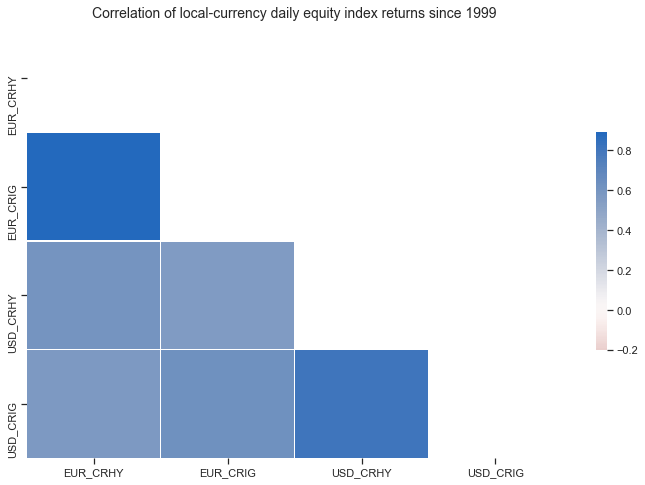

In [41]:
dfd_crxr_piv = dfd_crxr.pivot(index='release_date', columns='xcid', values = 'value')
corr = dfd_crxr_piv.corr()  # compute correlation matrix

sns.set(rc={'figure.figsize':(12, 8)}, style="ticks") 
mask = np.triu(np.ones_like(corr, dtype=bool))  # generate mask for upper triangle
ax = sns.heatmap(corr, mask=mask, cmap='vlag_r', vmin = -0.2, center=0,
                 square=False, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation of local-currency daily equity index returns since 1999', y = 1, fontsize=14)
ax.set(xlabel='', ylabel='')
plt.show()

## Carry

### Distribution

In [42]:
needed = ['xcid', 'cat', 'release_date', 'value']
filt1 = dfd['cat'] == 'CRY'
filt2 = dfd['release_date'] >= pd.to_datetime('01-06-1999')
dfd_cry = dfd[filt1 & filt2].sort_values(['xcid', 'release_date'])[needed]\
    .reset_index(drop=True)

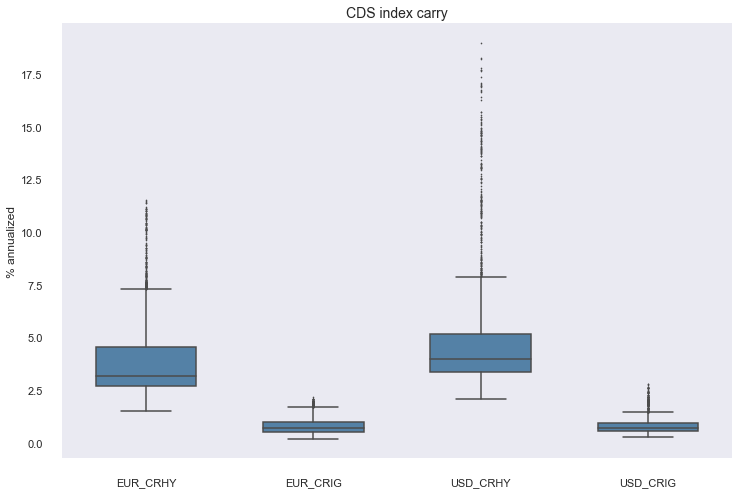

In [45]:
sns.set(rc={'figure.figsize':(12, 8)}, style="darkgrid")
ax = sns.boxplot(data=dfd_cry,
            x="xcid", y="value", color = 'steelblue',
            width=0.6, fliersize = 0.8)
sns.despine(offset=10, trim=False)
ax.set_title('CDS index carry', y = 1, fontsize=14)
ax.set(xlabel='', ylabel='% annualized')
plt.grid(axis='y')
plt.show()

### Timeline

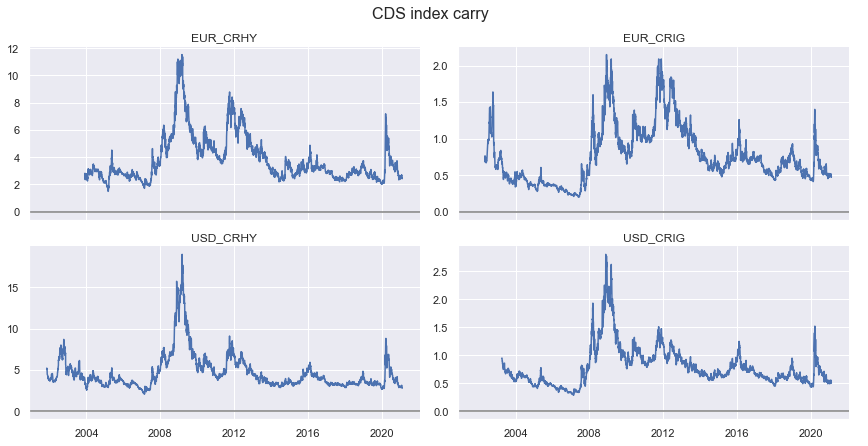

In [46]:
fg = sns.FacetGrid(dfd_cry, col='xcid', col_wrap = 2, sharey=False, aspect = 2)
fg.map_dataframe(sns.lineplot, x='release_date', y='value')
fg.map(plt.axhline, y=0, c=".5")
fg.set_titles(col_template='{col_name}')
fg.fig.suptitle("CDS index carry", size=16, y=1.03)
fg.add_legend()
plt.show()

### Correlation

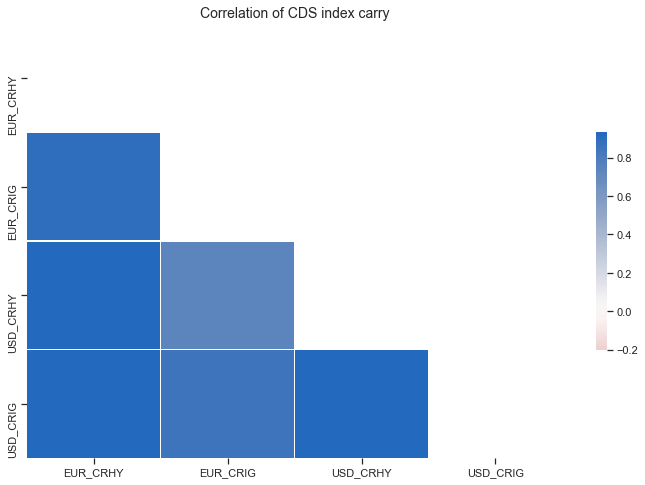

In [48]:
dfd_cry_piv = dfd_cry.pivot(index='release_date', columns='xcid', values = 'value')
corr = dfd_cry_piv.corr()  # compute correlation matrix

sns.set(rc={'figure.figsize':(12, 8)}, style="ticks") 
mask = np.triu(np.ones_like(corr, dtype=bool))  # generate mask for upper triangle
ax = sns.heatmap(corr, mask=mask, cmap='vlag_r', vmin = -0.2, center=0,
                 square=False, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation of CDS index carry', y = 1, fontsize=14)
ax.set(xlabel='', ylabel='')
plt.show()